In [1]:
import os
import cv2     # for capturing videos
import math 
import keras
import geocoder
import requests
%matplotlib inline
import pandas as pd
from twilio.rest import Client
from geopy.geocoders import Nominatim
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from matplotlib import pyplot as plt 
from skimage.transform import resize   # for resizing images

In [2]:
count = 0
videoFile = "Accidents.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


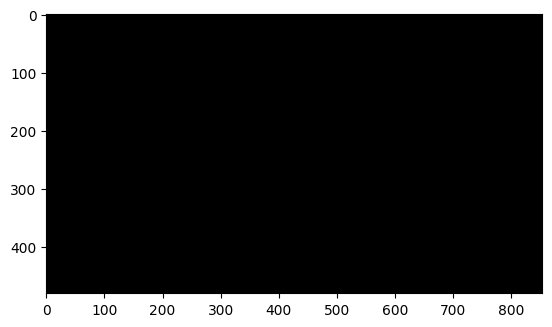

In [3]:
img = plt.imread('0.jpg')   # reading image using its name
plt.imshow(img)

In [4]:
data = pd.read_csv('mapping.csv')     # reading the csv file
data.head()

,Image_ID,Class
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [5]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

In [6]:
y = data.Class
dummy_y = keras.utils.to_categorical(y)

In [7]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [8]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X,data_format=None)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

In [10]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

In [12]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step


((155, 7, 7, 512), (67, 7, 7, 512))

In [13]:
X_train = X_train.reshape(155, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(67, 7*7*512)

In [14]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [15]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(2, activation='softmax'))    # output layer

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,693,186 (98.01 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.3962 - loss: 1.0791 - val_accuracy: 0.5522 - val_loss: 0.9513
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.7190 - loss: 0.4935 - val_accuracy: 0.6866 - val_loss: 0.8471
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.8338 - loss: 0.2910 - val_accuracy: 0.6716 - val_loss: 0.8499
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.9580 - loss: 0.1594 - val_accuracy: 0.7313 - val_loss: 0.8648
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.9402 - loss: 0.1415 - val_accuracy: 0.7463 - val_loss: 0.8311
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.9931 - loss: 0.0778 - val_accuracy: 0.7313 - val_loss: 0.8723
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 1.0000 - loss: 0.0518 - val_accuracy: 0.7313 - val_loss: 0.8445
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9965 - loss: 0.0412 - val_accuracy: 0.7463 - v

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
count = 0
videoFile = "Accident-1.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [21]:
test = pd.read_csv('test.csv')

In [22]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [23]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [24]:
# preprocessing the images
test_image = preprocess_input(test_image, data_format=None)

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)
test_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(9, 7, 7, 512)

In [25]:
test_image = test_image.reshape(9, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [26]:
predictions = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [27]:
print(predictions)

[[1.4926377e-05 9.9998510e-01]
 [5.8426999e-04 9.9941576e-01]
 [5.3125131e-03 9.9468744e-01]
 [2.9281366e-03 9.9707186e-01]
 [7.7854516e-03 9.9221450e-01]
 [6.0537428e-01 3.9462578e-01]
 [8.2969058e-01 1.7030948e-01]
 [6.6187626e-01 3.3812368e-01]
 [8.9196014e-01 1.0803986e-01]]


In [28]:
for i in range (0,9):
    if predictions[i][0]<predictions[i][1]:
        print("No Accident")
    else:
        print("Accident")
    

No Accident
No Accident
No Accident
No Accident
No Accident
Accident
Accident
Accident
Accident


In [29]:
geoLoc = Nominatim(user_agent="GetLoc")
g = geocoder.ip('me')
locname = geoLoc.reverse(g.latlng)
account_sid = "ACaed7bd71969cb0fd26adbb89267944a5",
auth_token = "8c0203f3b4a04caba00935ac5bbfe106",
client = Client(account_sid, auth_token)

In [30]:
cap = cv2.VideoCapture('Accident-1.mp4')
i=0
flag=0
while(True):
    ret,frame=cap.read()
    if ret==True:
        if predictions[int(i/15)%9][0]<predictions[int(i/15)%9][1]:
            predict="No Accident"
        else:
            predict="Accident"
            flag=1
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,
                predict,
                (50, 50),
                font, 1,
                (0, 255, 255),
                3,
                cv2.LINE_4)
        cv2.imshow('Frame', frame)
        i=i+1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
# Update the Twilio account credentials with the correct values
account_sid = "ACaed7bd71969cb1fd26cdab63267944a5"
auth_token = "8c0103f3b4b04caba00225bd4bbfe106"

if flag == 1:
    client = Client(account_sid, auth_token)
    client.messages.create(
        body="Accident detected in " + locname.address,
        from_="+13123637435",
        to="+914567436292"
    )

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()
